## Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [2]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.571268,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.007613,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Pre Processing

In [3]:
###Check missing data
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [4]:
###Delete feature
data = data.drop(data.columns[[0, 3, 8, 10]], axis=1)
test = test.drop(test.columns[[0, 3, 8, 10]], axis=1)



In [5]:
#Label Encoder các dữ liệu string
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
lb = label_encoder.fit_transform(data['Sex']) 
data['Sex'] = lb

label_encoder = LabelEncoder()
lb = label_encoder.fit_transform(data['Embarked']) 
data['Embarked'] = lb


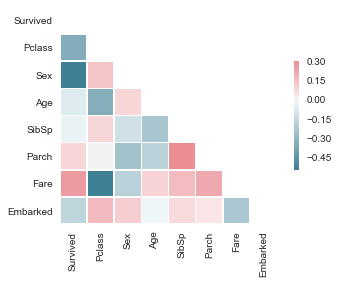

In [6]:
#Correlation

sns.set(style="white")
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
#splitting data to train and validation
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data, test_size=0.2)

combined_cleaned = {"train":train,
            "valid":valid,
            "test":test}

#combined_cleaned['train']

In [8]:

from sklearn import preprocessing,tree
from sklearn.model_selection import GridSearchCV

tree_data = {}
tree_data_category = {}

for i,data in combined_cleaned.items():
    tree_data[i] = data

In [9]:
#finding best fit with gridsearch
param_grid = {'min_samples_leaf':np.arange(20,50,5),
              'min_samples_split':np.arange(20,50,5),
              'max_depth':np.arange(3,6),
              'min_weight_fraction_leaf':np.arange(0,0.4,0.1),
              'criterion':['gini']}
clf = tree.DecisionTreeClassifier()
tree_search = GridSearchCV(clf, param_grid, scoring='average_precision')

X = combined_cleaned["train"].drop("Survived",axis = 1)
Y = combined_cleaned["train"]["Survived"]
tree_search.fit(X,Y)

print("Tree best parameters :",tree_search.best_params_)
print("Tree best estimator :",tree_search.best_estimator_ )
print("Tree best score :",tree_search.best_score_ )

Tree best parameters : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 25, 'min_samples_split': 25, 'min_weight_fraction_leaf': 0.0}
Tree best estimator : DecisionTreeClassifier(max_depth=5, min_samples_leaf=25, min_samples_split=25)
Tree best score : 0.8291716802875151


In [13]:
tree_best_parameters = tree_search.best_params_
tree_optimized = tree.DecisionTreeClassifier(**tree_best_parameters)
tree_optimized.fit(X,Y)
train_columns = list(tree_data["train"].columns)
if 'Survived' in train_columns:
    train_columns.remove('Survived')
label = combined_cleaned["train"]["Survived"].unique()
label = label.astype(str)
print(train_columns, label)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'] ['1' '0']


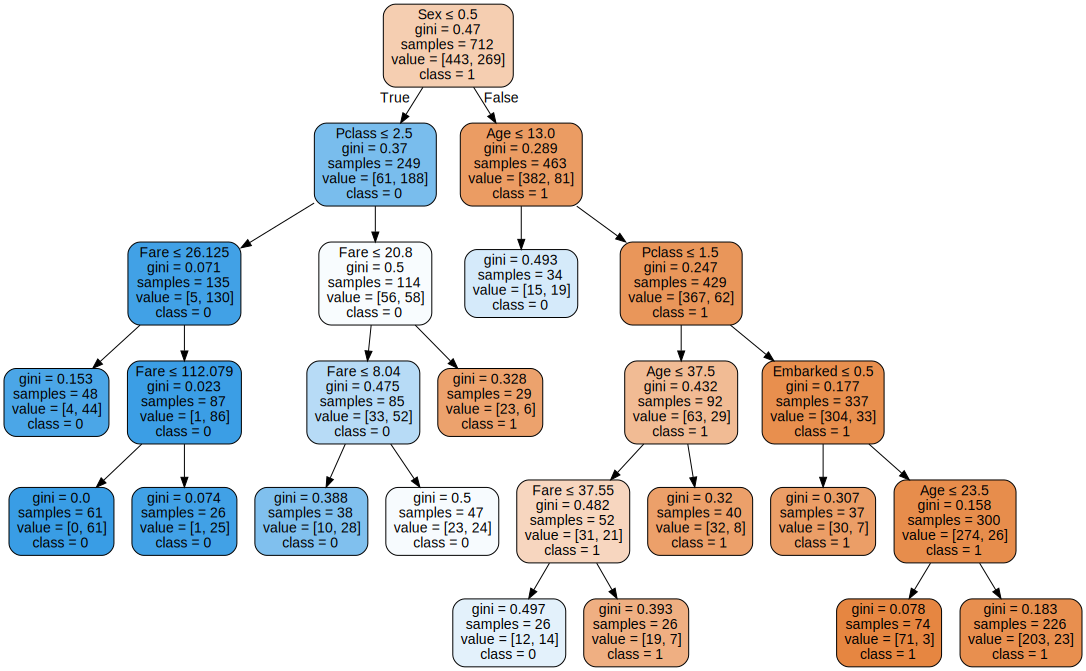

In [14]:
import graphviz 
dot_data = tree.export_graphviz(tree_optimized, 
                                out_file=None,
                                filled=True, 
                                rounded=True,  
                                special_characters=True,
                               feature_names = train_columns,
                               class_names = label) 
graph = graphviz.Source(dot_data)
graph

## Performance evaluation

0    106
1     73
Name: Survived, dtype: int64
[[0.82075472 0.17924528]
 [0.35616438 0.64383562]]


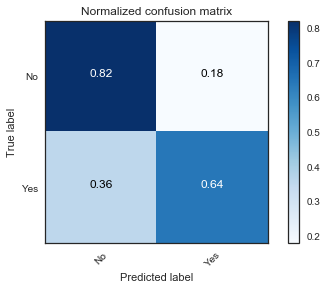

In [22]:
from sklearn.metrics import confusion_matrix

evaluation = {}
cm = {}


valid_without_PId = tree_data["valid"].drop("Survived",axis=1)
evaluation["tree"] = tree_optimized.predict(valid_without_PId).astype(int)
survival_from_data = combined_cleaned["valid"]["Survived"].astype(int)

print(survival_from_data.value_counts())

cm["tree"] = confusion_matrix(survival_from_data, evaluation["tree"])
cm["tree"] = cm["tree"].astype('float') / cm["tree"].sum(axis=1)[:, np.newaxis]

cm["tree"]

plot_confusion_matrix(cm["tree"], classes=["No","Yes"], 
                      title='Normalized confusion matrix')

In [23]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Into the woods - random forest


In [24]:
from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier(n_estimators=10,min_samples_leaf=20, max_depth=4,min_weight_fraction_leaf=0.1)
clf_forest.fit(X,Y)

RandomForestClassifier(max_depth=4, min_samples_leaf=20,
                       min_weight_fraction_leaf=0.1, n_estimators=10)

## Random forest with parameters optimization

In [25]:


param_grid = {'n_estimators':np.arange(3,11,2),
              'max_depth':np.arange(3,6),
              'min_weight_fraction_leaf':np.arange(0,0.4,0.1),
              'criterion':['gini','entropy']}
clf = RandomForestClassifier()
forest_search = GridSearchCV(clf, param_grid, scoring='precision')

forest_search.fit(X,Y)

print("Forest best parameters :",forest_search.best_params_)
print("Forest best estimator :",forest_search.best_estimator_ )
print("Forest best score :",forest_search.best_score_ )



C:\Users\LENOVO\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python36\site-packages

In [20]:
clf_forest = RandomForestClassifier(**forest_search.best_params_)
clf_forest.fit(X,Y)

RandomForestClassifier(max_depth=5,
                       min_weight_fraction_leaf=0.30000000000000004,
                       n_estimators=9)

## Performance evaluation

[[0.87735849 0.12264151]
 [0.47945205 0.52054795]]


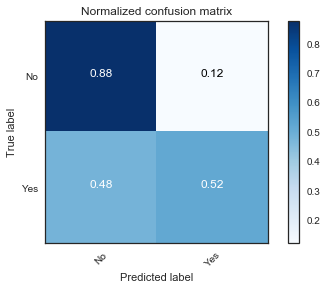

In [26]:
evaluation["forest"] = clf_forest.predict(valid_without_PId).astype(int)

cm["forest"] = confusion_matrix(survival_from_data, evaluation["forest"])
cm["forest"] = cm["forest"].astype('float') / cm["forest"].sum(axis=1)[:, np.newaxis]

cm["forest"]

plot_confusion_matrix(cm["forest"], classes=["No","Yes"], 
                      title='Normalized confusion matrix')

## Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X, Y)

GaussianNB()

## Performance evaluation

[[0.81132075 0.18867925]
 [0.30136986 0.69863014]]


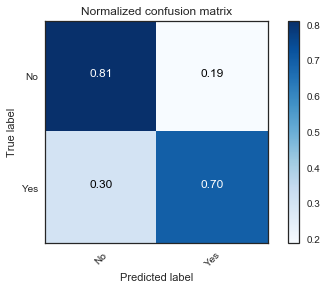

In [29]:
evaluation["NB"] = gnb.predict(valid_without_PId).astype(int)

cm["NB"] = confusion_matrix(survival_from_data, evaluation["NB"])
cm["NB"] = cm["NB"].astype('float') / cm["NB"].sum(axis=1)[:, np.newaxis]

cm["NB"]

plot_confusion_matrix(cm["NB"], classes=["No","Yes"], 
                      title='Normalized confusion matrix')